In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


PLAY A FEW OF OUR SAMPLES:

In [ ]:
import IPython.display as ipd
belly_pain = "/content/drive/MyDrive/Cry_Dataset/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138495-1.0-m-72-bp.wav"
ipd.Audio(belly_pain)

In [ ]:
burping ="/content/drive/MyDrive/Cry_Dataset/5afc6a14-a9d8-45f8-b31d-c79dd87cc8c6-1430757039803-1.7-m-48-bu.wav"
ipd.Audio(burping)

In [ ]:
discomfort = "/content/drive/MyDrive/Cry_Dataset/2294E2B2-8E36-4DA6-A898-B947CB9446AB-1436462707-1.1-m-26-dc.wav"
ipd.Audio(discomfort)

In [ ]:
hungry = "/content/drive/MyDrive/Cry_Dataset/1f40790f-68f2-4e7e-845e-715bd97c82d0-1429979603276-1.7-m-72-hu.wav"
ipd.Audio(hungry)

In [ ]:
tired = "/content/drive/MyDrive/Cry_Dataset/5B416CE8-2591-4531-9ADC-86D085B5D48B-1430144827-1.0-m-48-ti.wav"
ipd.Audio(tired)

In [ ]:
cry= ["belly_pain", "burping", "discomfort", "hungry", "tired"]

Loading and Visualizing an audio file:
librosa.load: loads an audio file as a floating point time series and gives it's native sampling rate.
The sampling frequency (or sample rate) is the number of samples (data points) per second in an audio.
We can check the audio length by dividing the total number of data points by the sampling frequency.

In [ ]:
y, sr = librosa.load(belly_pain)
print('y:', y, '\n')
print('y shape:', np.shape(y))
print('Sample Rate (KHz):', sr, '\n')
print('Check Len of Audio:', np.shape(y)[0]/sr)

y: [ 1.3435269e-05  1.9215351e-04  3.2928897e-04 ... -1.6752114e-04
 -6.1805180e-04 -5.5282470e-04] 

y shape: (154350,)
Sample Rate (KHz): 22050 

Check Len of Audio: 7.0


In [ ]:
audio_file, _ = librosa.effects.trim(y)
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [ 1.3435269e-05  1.9215351e-04  3.2928897e-04 ... -1.6752114e-04
 -6.1805180e-04 -5.5282470e-04] 

Audio File shape: (154350,)


In [ ]:
y_belly_pain, sr_belly_pain = librosa.load(belly_pain)
audio_belly_pain, _ = librosa.effects.trim(y_belly_pain)

y_burping, sr_burping = librosa.load(burping)
audio_burping, _ = librosa.effects.trim(y_burping)

y_discomfort, sr_discomfort = librosa.load(discomfort)
audio_discomfort, _ = librosa.effects.trim(y_discomfort)

y_hungry, sr_hungry = librosa.load(hungry)
audio_hungry, _ = librosa.effects.trim(y_hungry)

y_tired, sr_tired = librosa.load(tired)
audio_tired, _ = librosa.effects.trim(y_tired)

Waveform Visualization

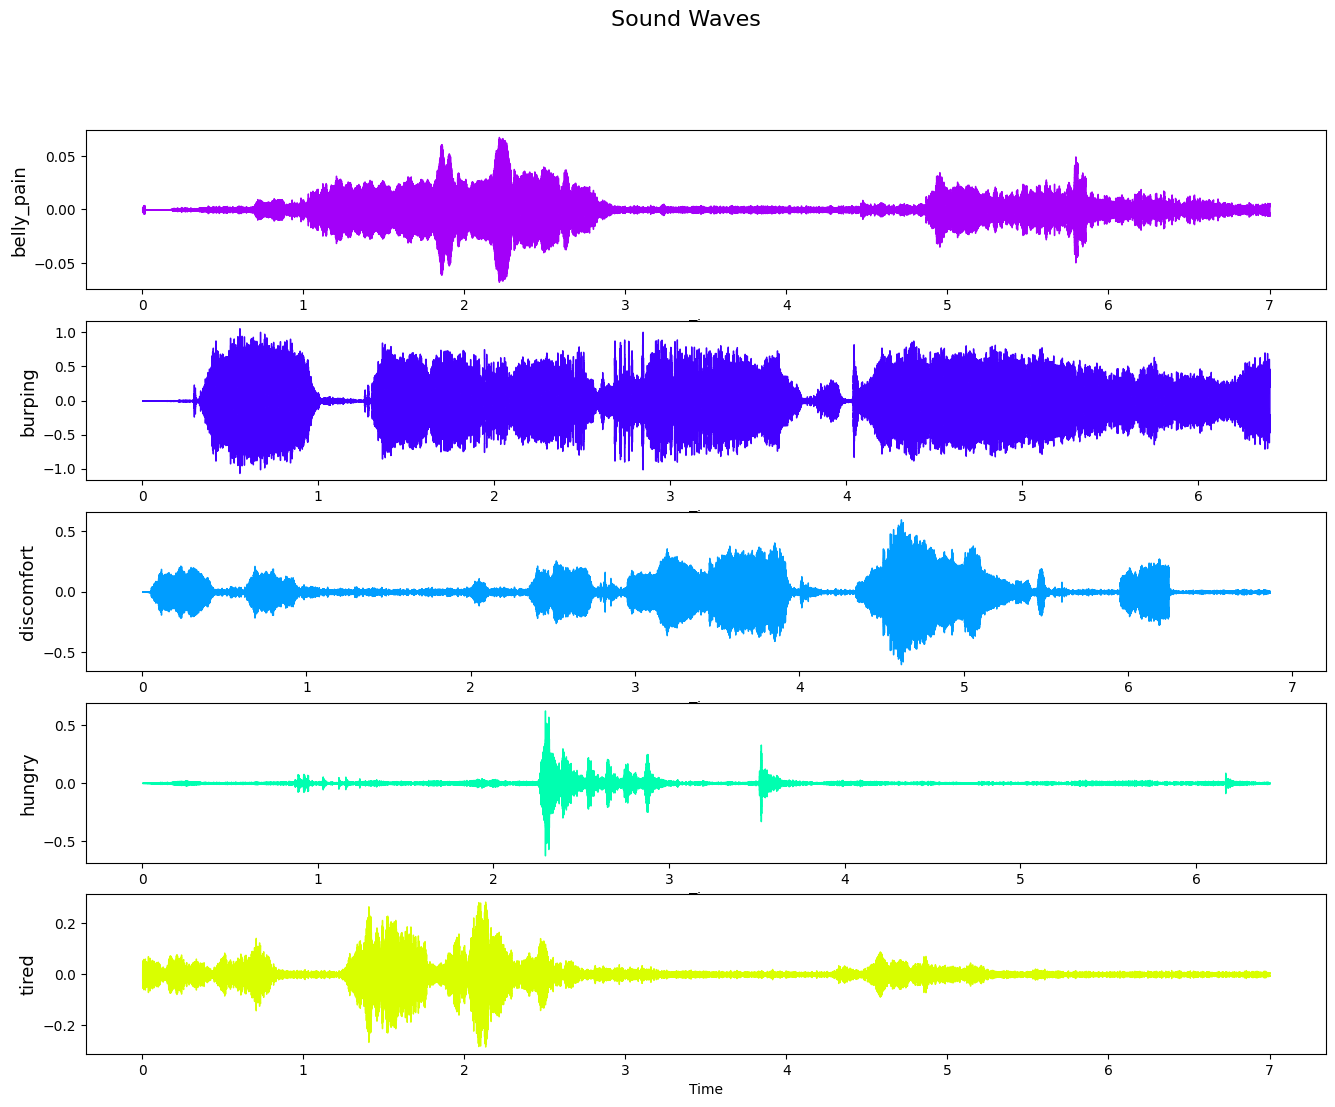

In [ ]:
fig, ax = plt.subplots(5, figsize = (16, 12))
fig.suptitle('Sound Waves', fontsize=16)

librosa.display.waveshow(y = audio_belly_pain, sr = sr_belly_pain, color = "#A300F9", ax=ax[0])
librosa.display.waveshow(y = audio_burping, sr = sr_burping, color = "#4300FF", ax=ax[1])
librosa.display.waveshow(y = audio_discomfort, sr = sr_discomfort, color = "#009DFF", ax=ax[2])
librosa.display.waveshow(y = audio_hungry, sr = sr_hungry, color = "#00FFB0", ax=ax[3])
librosa.display.waveshow(y = audio_tired, sr = sr_tired, color = "#D9FF00", ax=ax[4])

for i, name in zip(range(6), cry):
    ax[i].set_ylabel(name, fontsize=13)

Short-time Fourier transform (STFT)

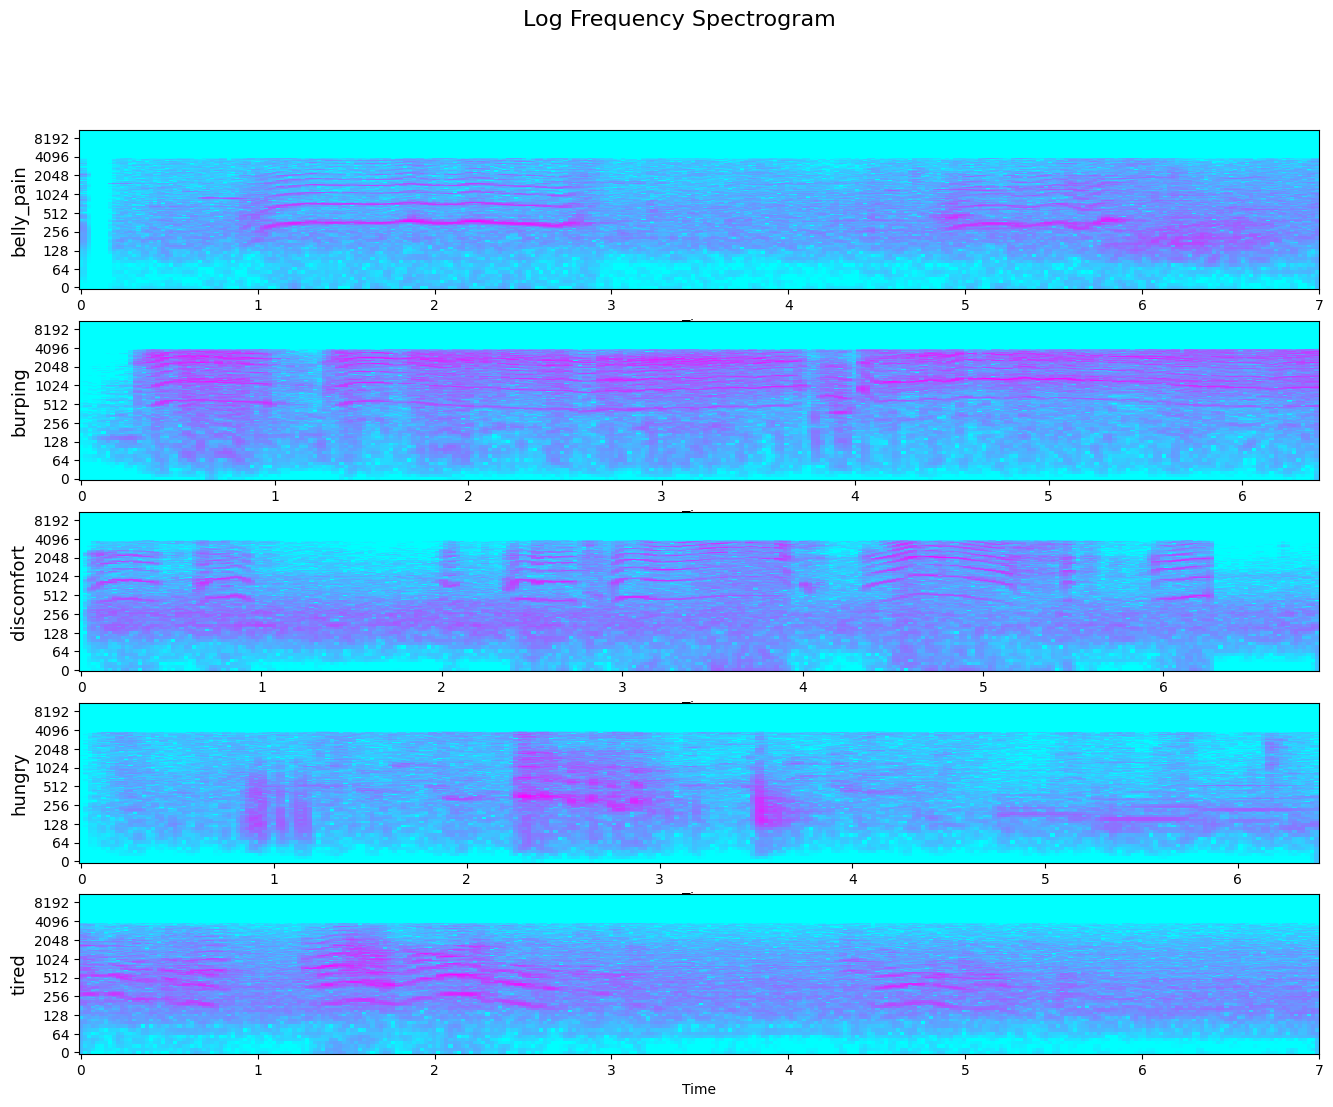

In [ ]:
n_fft=2048
hop_length=512
# Short-time Fourier transform (STFT)
D_belly_pain = np.abs(librosa.stft(audio_belly_pain, n_fft = n_fft, hop_length = hop_length))
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB_belly_pain = librosa.amplitude_to_db(D_belly_pain, ref = np.max)
# Short-time Fourier transform (STFT)
D_burping = np.abs(librosa.stft(audio_burping, n_fft = n_fft, hop_length = hop_length))
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB_burping = librosa.amplitude_to_db(D_burping, ref = np.max)
D_discomfort = np.abs(librosa.stft(audio_discomfort, n_fft = n_fft, hop_length = hop_length))
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB_discomfort = librosa.amplitude_to_db(D_discomfort, ref = np.max)
# Short-time Fourier transform (STFT)
D_hungry = np.abs(librosa.stft(audio_hungry, n_fft = n_fft, hop_length = hop_length))
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB_hungry = librosa.amplitude_to_db(D_hungry, ref = np.max)
# Short-time Fourier transform (STFT)
D_tired = np.abs(librosa.stft(audio_tired, n_fft = n_fft, hop_length = hop_length))
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB_tired = librosa.amplitude_to_db(D_tired, ref = np.max)

fig, ax = plt.subplots(5, figsize = (16, 12))
fig.suptitle('Log Frequency Spectrogram', fontsize=16)

librosa.display.specshow(DB_belly_pain, sr = sr_belly_pain, hop_length = hop_length, x_axis = 'time',
                         y_axis = 'log', cmap = 'cool', ax=ax[0])
librosa.display.specshow(DB_burping, sr = sr_burping, hop_length = hop_length, x_axis = 'time',
                         y_axis = 'log', cmap = 'cool', ax=ax[1])
librosa.display.specshow(DB_discomfort, sr = sr_discomfort, hop_length = hop_length, x_axis = 'time',
                         y_axis = 'log', cmap = 'cool', ax=ax[2])
librosa.display.specshow(DB_hungry, sr = sr_hungry, hop_length = hop_length, x_axis = 'time',
                         y_axis = 'log', cmap = 'cool', ax=ax[3])
librosa.display.specshow(DB_tired, sr = sr_tired, hop_length = hop_length, x_axis = 'time',
                         y_axis = 'log', cmap = 'cool', ax=ax[4])


for i, name in zip(range(6), cry):
    ax[i].set_ylabel(name, fontsize=13)

# Extract MFCCs for each cry class

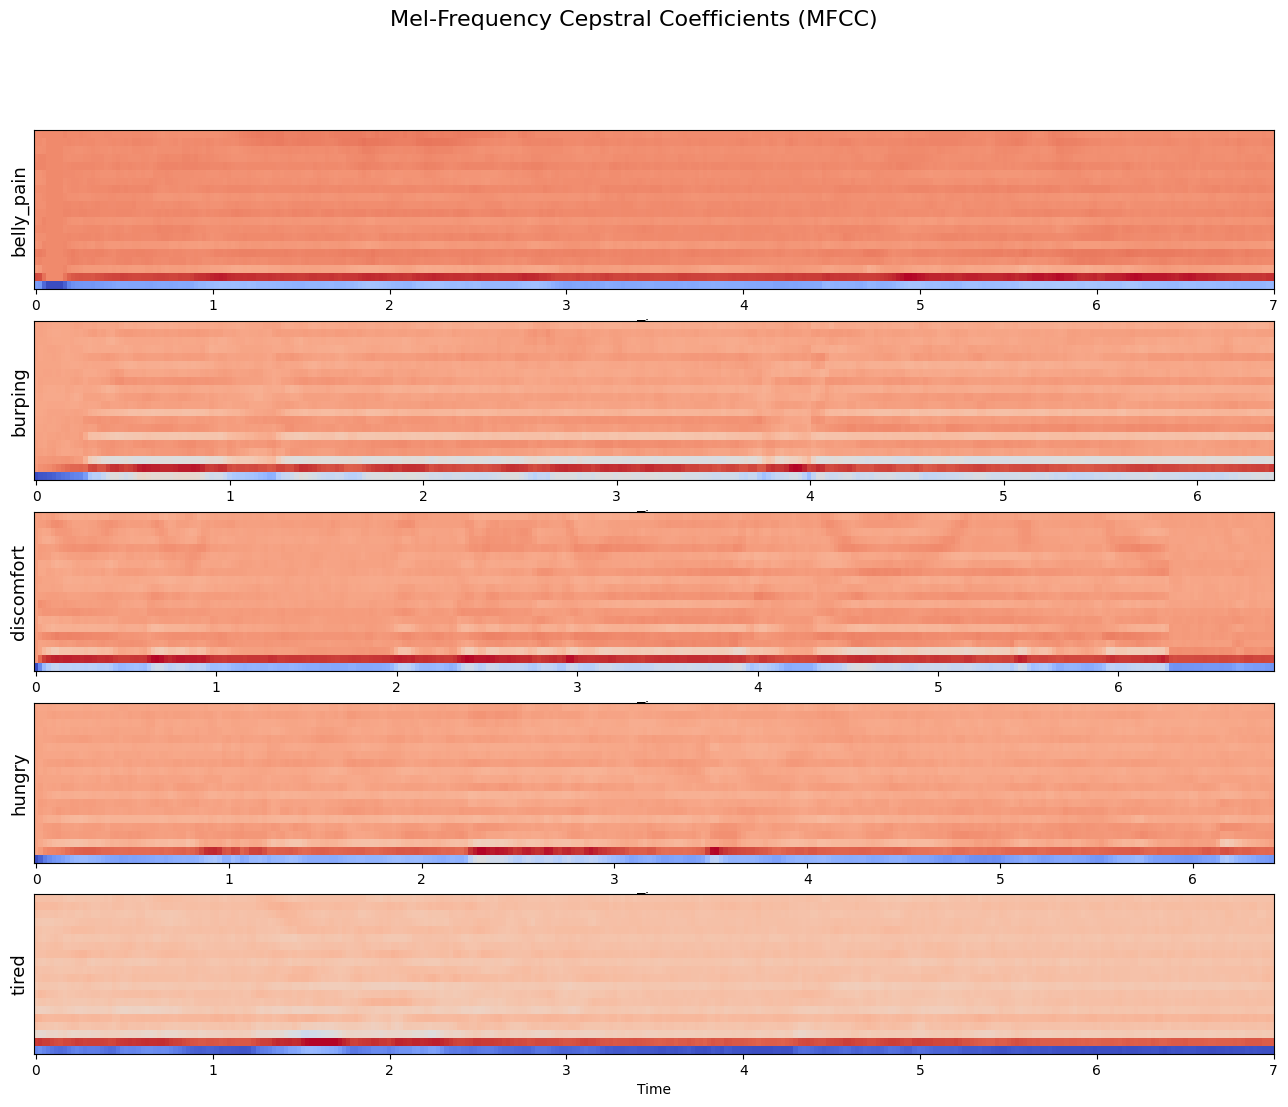

In [ ]:
n_fft = 2048
hop_length = 512

# Extract MFCCs for each cry class
mfcc_belly_pain = librosa.feature.mfcc(y=audio_belly_pain, sr=sr_belly_pain)
mfcc_burping = librosa.feature.mfcc(y=audio_burping, sr=sr_burping)
mfcc_discomfort = librosa.feature.mfcc(y=audio_discomfort, sr=sr_discomfort)
mfcc_hungry = librosa.feature.mfcc(y=audio_hungry, sr=sr_hungry)
mfcc_tired = librosa.feature.mfcc(y=audio_tired, sr=sr_tired)

# Plot MFCCs for each cry class
fig, ax = plt.subplots(5, figsize=(16, 12))
fig.suptitle('Mel-Frequency Cepstral Coefficients (MFCC)', fontsize=16)

librosa.display.specshow(mfcc_belly_pain, x_axis='time',ax=ax[0])
librosa.display.specshow(mfcc_burping, x_axis='time', ax=ax[1])
librosa.display.specshow(mfcc_discomfort, x_axis='time',ax=ax[2])
librosa.display.specshow(mfcc_hungry, x_axis='time', ax=ax[3])
librosa.display.specshow(mfcc_tired, x_axis='time', ax=ax[4])


for i, name in zip(range(5), cry):
    ax[i].set_ylabel(name, fontsize=13)

Extract MFCCs for each cry class

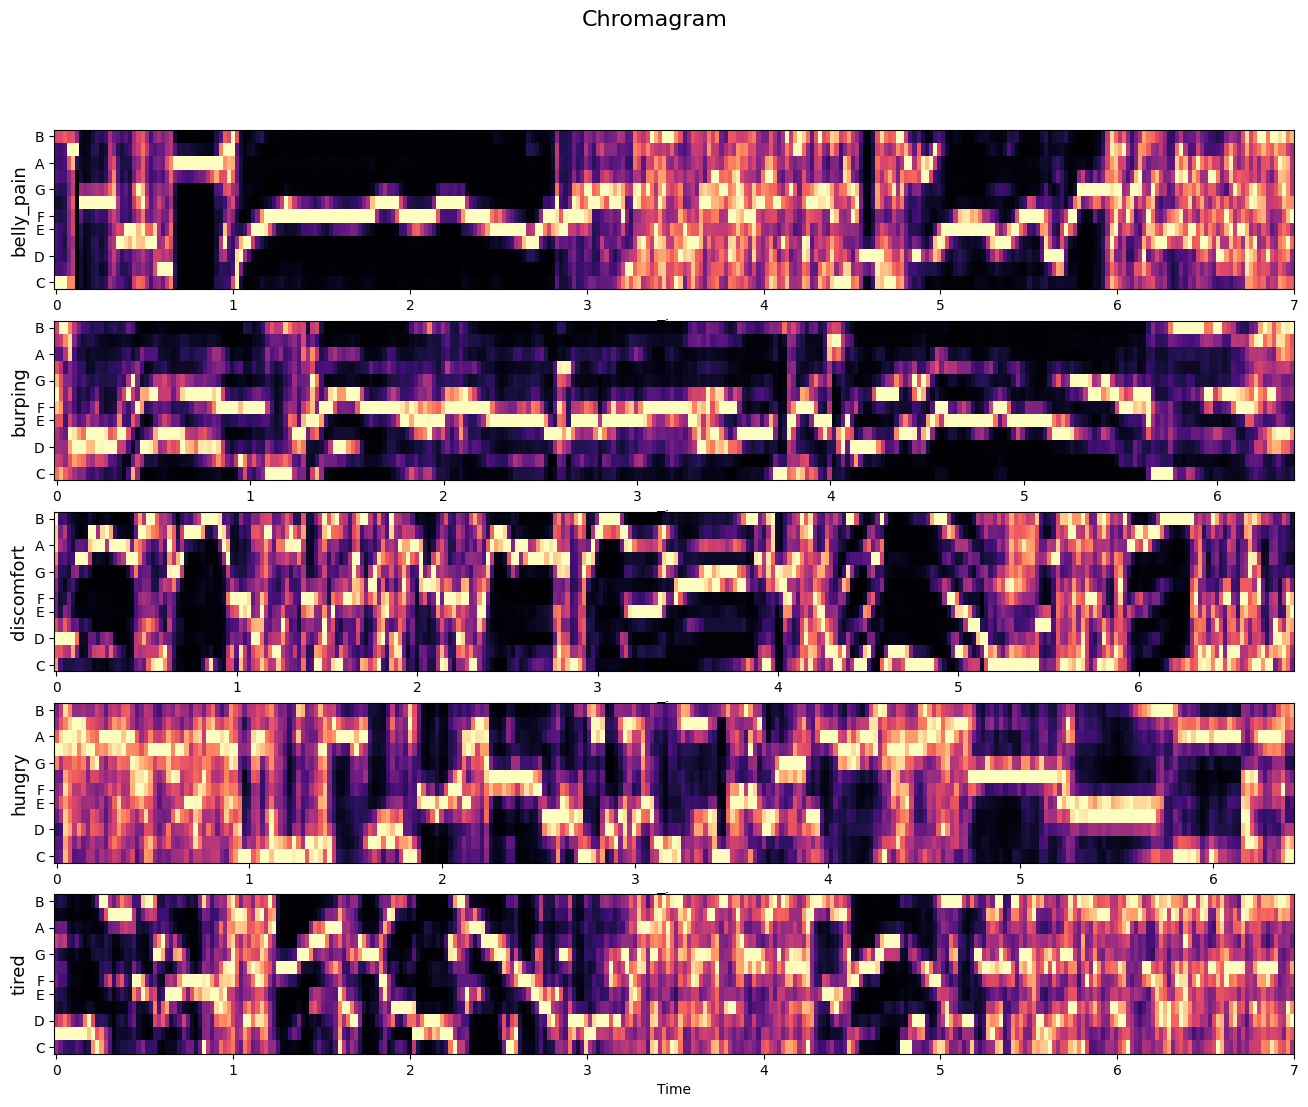

In [ ]:
n_fft = 2048
hop_length = 512

# Extract MFCCs for each cry class
chroma_belly_pain = librosa.feature.chroma_stft(y=audio_belly_pain, sr=sr_belly_pain)
chroma_burping = librosa.feature.chroma_stft(y=audio_burping, sr=sr_burping)
chroma_discomfort = librosa.feature.chroma_stft(y=audio_discomfort, sr=sr_discomfort)
chroma_hungry = librosa.feature.chroma_stft(y=audio_hungry, sr=sr_hungry)
chroma_tired = librosa.feature.chroma_stft(y=audio_tired, sr=sr_tired)

# Plot MFCCs for each cry class
fig, ax = plt.subplots(5, figsize=(16, 12))
fig.suptitle('Chromagram', fontsize=16)

librosa.display.specshow(chroma_belly_pain,y_axis='chroma', x_axis='time',ax=ax[0])
librosa.display.specshow(chroma_burping, y_axis='chroma',x_axis='time', ax=ax[1])
librosa.display.specshow(chroma_discomfort,y_axis='chroma', x_axis='time',ax=ax[2])
librosa.display.specshow(chroma_hungry,y_axis='chroma', x_axis='time', ax=ax[3])
librosa.display.specshow(chroma_tired,y_axis='chroma', x_axis='time', ax=ax[4])


for i, name in zip(range(5), cry):
    ax[i].set_ylabel(name, fontsize=13)

In [ ]:
import os

# Define the directory path
directory = "/content/drive/MyDrive/Cry_Dataset"

# Initialize a dictionary to store the frequency count
count = {}

# Iterate through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.wav'):
        # Get the last two characters of the file name
        key = filename[-6:-4]

        # Update the count dictionary
        count[key] = count.get(key, 0) + 1

# Print the frequency count
for key, value in count.items():
    print(f"Class {key}: {value} files")

Class hu: 382 files
Class ti: 24 files
Class dc: 20 files
Class bp: 16 files
Class bu: 8 files
Class ch: 7 files


In [ ]:
lst = []

label_mapping = {
    'bp': {'label': 0, 'needs': 'belly_pain'},
    'bu': {'label': 1, 'needs': 'burping'},
    'dc': {'label': 2, 'needs': 'discomfort'},
    'hu': {'label': 3, 'needs': 'hungry'},
    'ti': {'label': 4, 'needs': 'tired'},
    'ch': {'label': 2, 'needs': 'discomfort'}
}

for subdir, dirs, files in os.walk("/content/drive/MyDrive/Cry_Dataset"):
    for file in files:
        try:
            X, sample_rate = librosa.load(os.path.join(subdir, file))
            file_class = file[-6:-4]

            # Map file class to the corresponding label and class
            mapping = label_mapping.get(file_class)
            if mapping is None:
                continue  # Skip the file if the class is not recognized

            class_name = mapping['needs']
            arr = class_name, os.path.join(subdir, file)
            lst.append(arr)
        except ValueError as err:
            print(err)
            continue

# Create a DataFrame with the class and file columns
crydata = pd.DataFrame(lst, columns=['needs', 'file'])

# Print the DataFrame
print(crydata)


      needs                                               file
0    hungry  /content/drive/MyDrive/Cry_Dataset/9fe37482-6a...
1    hungry  /content/drive/MyDrive/Cry_Dataset/a7b13b65-da...
2    hungry  /content/drive/MyDrive/Cry_Dataset/D1CB71F9-EF...
3    hungry  /content/drive/MyDrive/Cry_Dataset/24f94b49-c8...
4    hungry  /content/drive/MyDrive/Cry_Dataset/999bf14b-e4...
..      ...                                                ...
452  hungry  /content/drive/MyDrive/Cry_Dataset/0c8f14a9-69...
453  hungry  /content/drive/MyDrive/Cry_Dataset/40a4c760-fa...
454   tired  /content/drive/MyDrive/Cry_Dataset/B2AABCE0-1F...
455  hungry  /content/drive/MyDrive/Cry_Dataset/d6cda191-49...
456  hungry  /content/drive/MyDrive/Cry_Dataset/f896b69d-62...

[457 rows x 2 columns]


In [ ]:
# Perform count of categories in 'needs' column
category_counts = crydata['needs'].value_counts()

# Print the count of categories
print(category_counts)

hungry        382
discomfort     27
tired          24
belly_pain     16
burping         8
Name: needs, dtype: int64


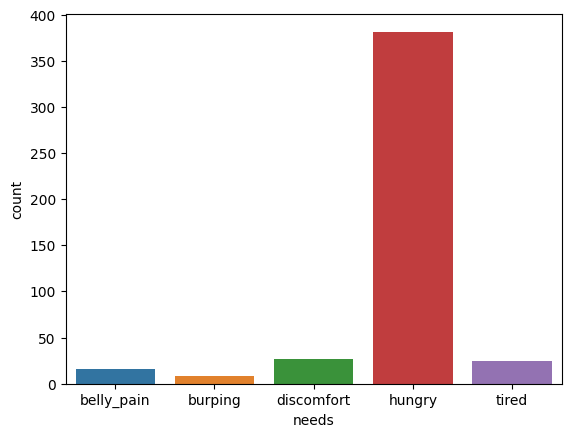

In [ ]:
# Convert the "class" column to categorical data
crydata['needs'] = pd.Categorical(crydata['needs'])

# Plot the count of each class
sns.countplot(data=crydata, x='needs')

# Show the plot
plt.show()

In [ ]:
count_class_0, count_class_1, count_class_2, count_class_3, count_class_4 = crydata.needs.value_counts()

crydata_class_0 = crydata[crydata['needs'] == 'hungry']
crydata_class_1 = crydata[crydata['needs'] =='tired']
crydata_class_2 = crydata[crydata['needs'] =='discomfort']
crydata_class_3 = crydata[crydata['needs'] =='belly_pain']
crydata_class_4 = crydata[crydata['needs'] =='burping']



In [ ]:
count_class_0, count_class_1, count_class_2, count_class_3, count_class_4

(382, 27, 24, 16, 8)

In [ ]:
crydata_class_0.shape

(382, 2)

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
file = np.array(crydata.file)[1]
data, sample_rate = librosa.load("/content/drive/MyDrive/Cry_Dataset/02c3b725-26e4-4a2c-9336-04ddc58836d9-1430726196216-1.7-m-04-hu.wav")

1. Simple Audio

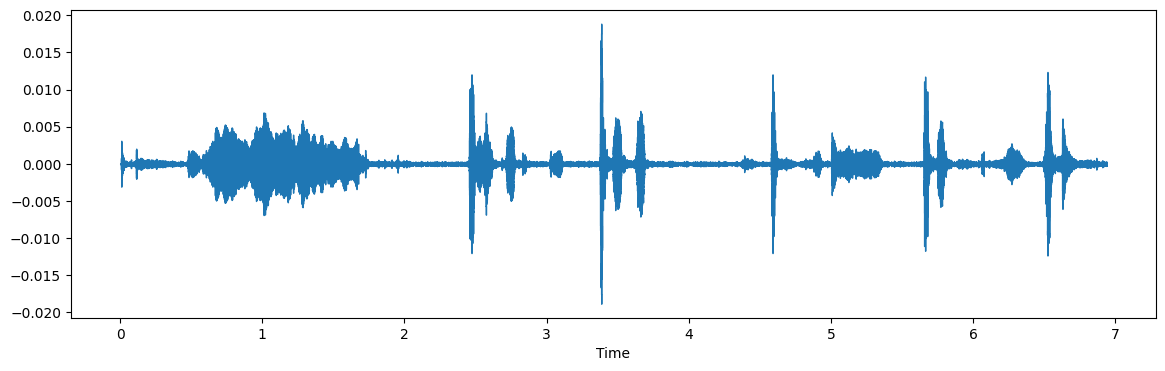

In [ ]:
from IPython.display import Audio
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(file)

2. Noise Injection

22050


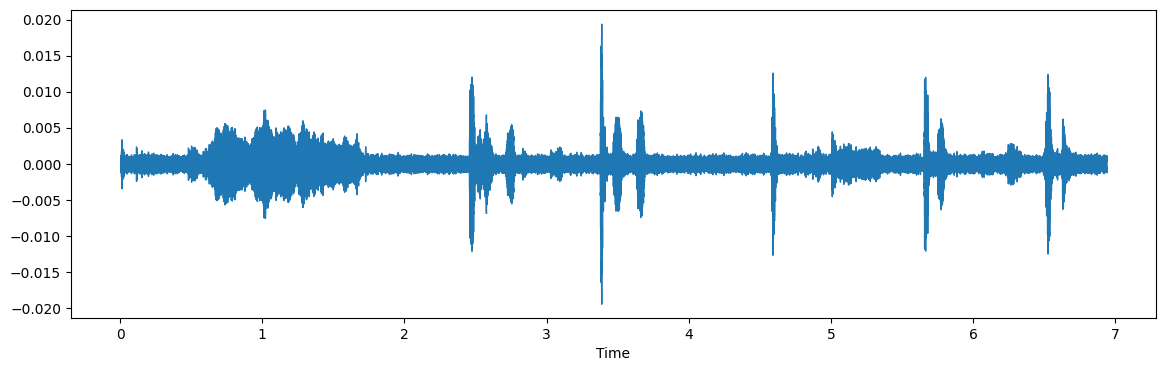

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)
print(sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

3. Stretching

<Figure size 1400x400 with 0 Axes>

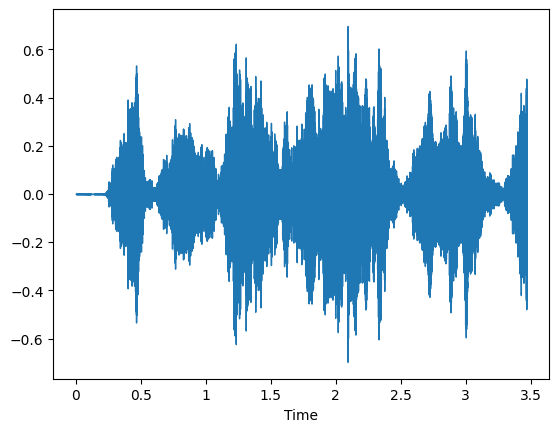

<Figure size 1400x400 with 0 Axes>

In [ ]:
# x = stretch(data)
# librosa.display.waveshow(y=x, sr=sample_rate)
# Audio(x, rate=sample_rate)

y, sr = librosa.load(file)
y_fast = librosa.effects.time_stretch(y, rate=2.0)
librosa.display.waveshow(y = y_fast, sr=sample_rate)
Audio(y_fast, rate=sample_rate)
plt.figure(figsize=(14,4))

4. Shifting

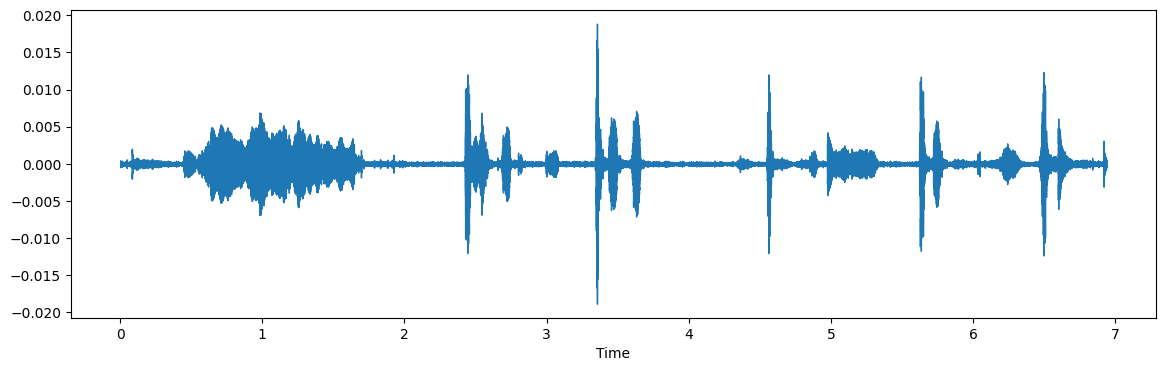

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

5. Pitch

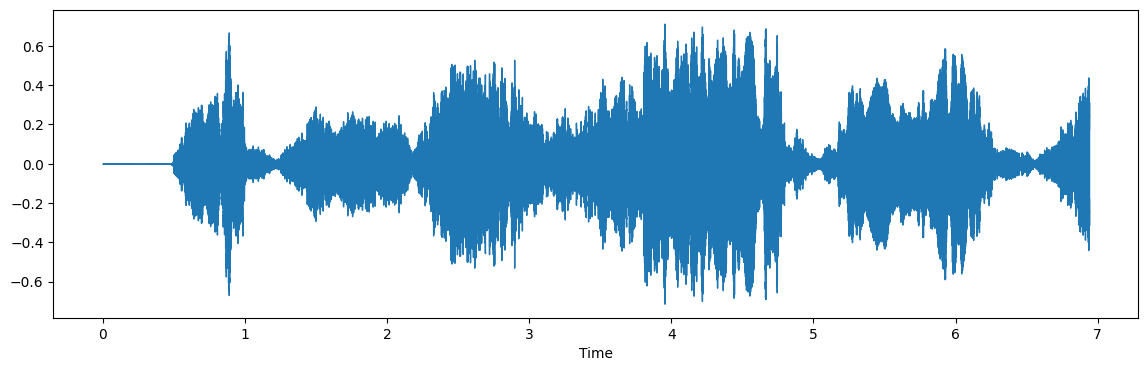

In [ ]:
# x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
# y, sr = librosa.load(file)
y_pitch = librosa.effects.pitch_shift(y, sr = sr, n_steps = 0.5)
librosa.display.waveshow(y=y_pitch, sr=sample_rate)
Audio(y_pitch, rate=sample_rate)

Feature Extraction

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(file):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(file, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    # new_data = stretch(data)
    new_data = librosa.effects.time_stretch(y, rate=2.0)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    data_stretch_pitch = librosa.effects.pitch_shift(y, sr = sr, n_steps = 3)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, need in zip(crydata.file, crydata.needs):
    feature = get_features(file)
    for ele in feature:
        X.append(ele)
        # appending needs 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(need)

In [ ]:
len(X), len(Y), crydata.file.shape

(1371, 1371, (457,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.098081,0.301163,0.294922,0.340659,0.342629,0.315904,0.374722,0.566886,0.688061,0.388440,...,2.503109e-06,2.294043e-06,2.116462e-06,1.965694e-06,1.841944e-06,1.745267e-06,1.671966e-06,1.621812e-06,1.591293e-06,hungry
1,0.104031,0.318873,0.311678,0.355938,0.357591,0.328840,0.375376,0.559777,0.696129,0.405358,...,1.630645e-03,1.650097e-03,1.620811e-03,1.570190e-03,1.650144e-03,1.735626e-03,1.717170e-03,1.683507e-03,1.696814e-03,hungry
2,0.115963,0.451742,0.413668,0.359920,0.305024,0.295577,0.316866,0.394551,0.448621,0.360897,...,3.558131e-08,2.844931e-08,3.209407e-08,2.485062e-08,3.132481e-08,2.335351e-08,2.149661e-08,1.516056e-08,2.689797e-09,hungry
3,0.098081,0.301163,0.294922,0.340659,0.342629,0.315904,0.374722,0.566886,0.688061,0.388440,...,2.503109e-06,2.294043e-06,2.116462e-06,1.965694e-06,1.841944e-06,1.745267e-06,1.671966e-06,1.621812e-06,1.591293e-06,hungry
4,0.143749,0.398518,0.388796,0.405947,0.432294,0.411407,0.380872,0.481077,0.705716,0.619333,...,4.217293e-02,4.272358e-02,4.120847e-02,4.113051e-02,4.032022e-02,3.957503e-02,4.223825e-02,4.265054e-02,4.406124e-02,hungry


Data Preparation

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:

# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)


In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=15, stratify = Y, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4011, 162), (4011, 5), (1719, 162), (1719, 5))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4011, 162, 1), (4011, 5), (1719, 162, 1), (1719, 5))

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((4011, 162, 1, 1), (4011, 5), (1719, 162, 1, 1), (1719, 5))

In [ ]:
import tensorflow as tf
from keras import layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(5,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 162, 512)          3072      
                                                                 
 batch_normalization_12 (Bat  (None, 162, 512)         2048      
 chNormalization)                                                
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 81, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 81, 512)           1311232   
                                                                 
 batch_normalization_13 (Bat  (None, 81, 512)          2048      
 chNormalization)                                                
                                                      

In [ ]:
history = model.fit(x_traincnn, y_train, epochs=100, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 1.9190 - accuracy: 0.2152

63/63 [==============================] - 93s 1s/step - loss: 1.9190 - accuracy: 0.2152 - val_loss: 2.3591 - val_accuracy: 0.2001 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 1.6696 - accuracy: 0.2211

63/63 [==============================] - 85s 1s/step - loss: 1.6696 - accuracy: 0.2211 - val_loss: 1.7623 - val_accuracy: 0.2001 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 1.6124 - accuracy: 0.2543

63/63 [==============================] - 88s 1s/step - loss: 1.6124 - accuracy: 0.2543 - val_loss: 1.8317 - val_accuracy: 0.2001 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 1.5841 - accuracy: 0.2578

63/63 [==============================] - 83s 1s/step - loss: 1.5841 - accuracy: 0.2578 - val_loss: 1.9256 - val_accuracy: 0.2001 - lr: 0.0010
Epoch 5/100
63/63 [==============================] - ETA: 0s - loss: 1.5760 - accuracy: 0.2660

63/63 [==============================] - 84s 1s/step - loss: 1.5760 - accuracy: 0.2660 - val_loss: 2.2454 - val_accuracy: 0.2001 - lr: 0.0010
Epoch 6/100
63/63 [==============================] - ETA: 0s - loss: 1.5537 - accuracy: 0.2847

63/63 [==============================] - 88s 1s/step - loss: 1.5537 - accuracy: 0.2847 - val_loss: 2.6002 - val_accuracy: 0.2036 - lr: 0.0010
Epoch 7/100
63/63 [==============================] - ETA: 0s - loss: 1.5286 - accuracy: 0.2959

63/63 [==============================] - 87s 1s/step - loss: 1.5286 - accuracy: 0.2959 - val_loss: 2.0380 - val_accuracy: 0.2234 - lr: 0.0010
Epoch 8/100
63/63 [==============================] - ETA: 0s - loss: 1.5085 - accuracy: 0.2952

63/63 [==============================] - 87s 1s/step - loss: 1.5085 - accuracy: 0.2952 - val_loss: 3.2497 - val_accuracy: 0.1995 - lr: 0.0010
Epoch 9/100
63/63 [==============================] - ETA: 0s - loss: 1.4847 - accuracy: 0.3239

63/63 [==============================] - 87s 1s/step - loss: 1.4847 - accuracy: 0.3239 - val_loss: 2.8351 - val_accuracy: 0.1995 - lr: 0.0010
Epoch 10/100
63/63 [==============================] - ETA: 0s - loss: 1.4858 - accuracy: 0.3131

63/63 [==============================] - 82s 1s/step - loss: 1.4858 - accuracy: 0.3131 - val_loss: 2.9936 - val_accuracy: 0.2077 - lr: 0.0010
Epoch 11/100
63/63 [==============================] - ETA: 0s - loss: 1.4484 - accuracy: 0.3293

63/63 [==============================] - 82s 1s/step - loss: 1.4484 - accuracy: 0.3293 - val_loss: 2.4062 - val_accuracy: 0.2368 - lr: 0.0010
Epoch 12/100
63/63 [==============================] - ETA: 0s - loss: 1.4296 - accuracy: 0.3313

63/63 [==============================] - 87s 1s/step - loss: 1.4296 - accuracy: 0.3313 - val_loss: 2.0158 - val_accuracy: 0.2507 - lr: 0.0010
Epoch 13/100
63/63 [==============================] - ETA: 0s - loss: 1.4319 - accuracy: 0.3373

63/63 [==============================] - 83s 1s/step - loss: 1.4319 - accuracy: 0.3373 - val_loss: 1.4563 - val_accuracy: 0.3421 - lr: 0.0010
Epoch 14/100
63/63 [==============================] - ETA: 0s - loss: 1.4173 - accuracy: 0.3441

63/63 [==============================] - 87s 1s/step - loss: 1.4173 - accuracy: 0.3441 - val_loss: 1.6724 - val_accuracy: 0.2914 - lr: 0.0010
Epoch 15/100
63/63 [==============================] - ETA: 0s - loss: 1.3948 - accuracy: 0.3523

63/63 [==============================] - 82s 1s/step - loss: 1.3948 - accuracy: 0.3523 - val_loss: 1.5811 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 16/100
63/63 [==============================] - ETA: 0s - loss: 1.3920 - accuracy: 0.3637

63/63 [==============================] - 87s 1s/step - loss: 1.3920 - accuracy: 0.3637 - val_loss: 1.3635 - val_accuracy: 0.3525 - lr: 0.0010
Epoch 17/100
63/63 [==============================] - ETA: 0s - loss: 1.3684 - accuracy: 0.3667

63/63 [==============================] - 86s 1s/step - loss: 1.3684 - accuracy: 0.3667 - val_loss: 1.3813 - val_accuracy: 0.3368 - lr: 0.0010
Epoch 18/100
63/63 [==============================] - ETA: 0s - loss: 1.3769 - accuracy: 0.3605

63/63 [==============================] - 83s 1s/step - loss: 1.3769 - accuracy: 0.3605 - val_loss: 1.3755 - val_accuracy: 0.3583 - lr: 0.0010
Epoch 19/100
63/63 [==============================] - ETA: 0s - loss: 1.3620 - accuracy: 0.3675

63/63 [==============================] - 83s 1s/step - loss: 1.3620 - accuracy: 0.3675 - val_loss: 1.4695 - val_accuracy: 0.3304 - lr: 0.0010
Epoch 20/100
63/63 [==============================] - ETA: 0s - loss: 1.3473 - accuracy: 0.3695

63/63 [==============================] - 87s 1s/step - loss: 1.3473 - accuracy: 0.3695 - val_loss: 1.3442 - val_accuracy: 0.3723 - lr: 0.0010
Epoch 21/100
63/63 [==============================] - ETA: 0s - loss: 1.3305 - accuracy: 0.3765

63/63 [==============================] - 82s 1s/step - loss: 1.3305 - accuracy: 0.3765 - val_loss: 1.4210 - val_accuracy: 0.3601 - lr: 0.0010
Epoch 22/100
63/63 [==============================] - ETA: 0s - loss: 1.3143 - accuracy: 0.3837

63/63 [==============================] - 87s 1s/step - loss: 1.3143 - accuracy: 0.3837 - val_loss: 1.7330 - val_accuracy: 0.3461 - lr: 0.0010
Epoch 23/100
63/63 [==============================] - ETA: 0s - loss: 1.3154 - accuracy: 0.3849

63/63 [==============================] - 87s 1s/step - loss: 1.3154 - accuracy: 0.3849 - val_loss: 1.3561 - val_accuracy: 0.3572 - lr: 0.0010
Epoch 24/100
63/63 [==============================] - ETA: 0s - loss: 1.3127 - accuracy: 0.3824

63/63 [==============================] - 86s 1s/step - loss: 1.3127 - accuracy: 0.3824 - val_loss: 1.3910 - val_accuracy: 0.3665 - lr: 0.0010
Epoch 25/100
63/63 [==============================] - ETA: 0s - loss: 1.3099 - accuracy: 0.3869

63/63 [==============================] - 87s 1s/step - loss: 1.3099 - accuracy: 0.3869 - val_loss: 1.3446 - val_accuracy: 0.3677 - lr: 0.0010
Epoch 26/100
63/63 [==============================] - ETA: 0s - loss: 1.2826 - accuracy: 0.3999

63/63 [==============================] - 84s 1s/step - loss: 1.2826 - accuracy: 0.3999 - val_loss: 1.3347 - val_accuracy: 0.3746 - lr: 0.0010
Epoch 27/100
63/63 [==============================] - ETA: 0s - loss: 1.2915 - accuracy: 0.3929

63/63 [==============================] - 87s 1s/step - loss: 1.2915 - accuracy: 0.3929 - val_loss: 1.3235 - val_accuracy: 0.3933 - lr: 0.0010
Epoch 28/100
63/63 [==============================] - ETA: 0s - loss: 1.2862 - accuracy: 0.4049

63/63 [==============================] - 86s 1s/step - loss: 1.2862 - accuracy: 0.4049 - val_loss: 1.3535 - val_accuracy: 0.3933 - lr: 0.0010
Epoch 29/100
63/63 [==============================] - ETA: 0s - loss: 1.2630 - accuracy: 0.4064

63/63 [==============================] - 87s 1s/step - loss: 1.2630 - accuracy: 0.4064 - val_loss: 1.3141 - val_accuracy: 0.3799 - lr: 0.0010
Epoch 30/100
63/63 [==============================] - ETA: 0s - loss: 1.2550 - accuracy: 0.4084

63/63 [==============================] - 86s 1s/step - loss: 1.2550 - accuracy: 0.4084 - val_loss: 1.5548 - val_accuracy: 0.3362 - lr: 0.0010
Epoch 31/100
63/63 [==============================] - ETA: 0s - loss: 1.2708 - accuracy: 0.3962

63/63 [==============================] - 82s 1s/step - loss: 1.2708 - accuracy: 0.3962 - val_loss: 1.3052 - val_accuracy: 0.3886 - lr: 0.0010
Epoch 32/100
63/63 [==============================] - ETA: 0s - loss: 1.2676 - accuracy: 0.3984

63/63 [==============================] - 88s 1s/step - loss: 1.2676 - accuracy: 0.3984 - val_loss: 1.3134 - val_accuracy: 0.3997 - lr: 0.0010
Epoch 33/100
63/63 [==============================] - ETA: 0s - loss: 1.2520 - accuracy: 0.4144

63/63 [==============================] - 83s 1s/step - loss: 1.2520 - accuracy: 0.4144 - val_loss: 1.2811 - val_accuracy: 0.3857 - lr: 0.0010
Epoch 34/100
63/63 [==============================] - ETA: 0s - loss: 1.2811 - accuracy: 0.3927

63/63 [==============================] - 86s 1s/step - loss: 1.2811 - accuracy: 0.3927 - val_loss: 1.4537 - val_accuracy: 0.3933 - lr: 0.0010
Epoch 35/100
63/63 [==============================] - ETA: 0s - loss: 1.2608 - accuracy: 0.4164

63/63 [==============================] - 87s 1s/step - loss: 1.2608 - accuracy: 0.4164 - val_loss: 1.4983 - val_accuracy: 0.3834 - lr: 0.0010
Epoch 36/100
63/63 [==============================] - ETA: 0s - loss: 1.2562 - accuracy: 0.4064

63/63 [==============================] - 87s 1s/step - loss: 1.2562 - accuracy: 0.4064 - val_loss: 1.3285 - val_accuracy: 0.3851 - lr: 0.0010
Epoch 37/100
63/63 [==============================] - ETA: 0s - loss: 1.2320 - accuracy: 0.4213

63/63 [==============================] - 82s 1s/step - loss: 1.2320 - accuracy: 0.4213 - val_loss: 1.3320 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 38/100
63/63 [==============================] - ETA: 0s - loss: 1.2566 - accuracy: 0.4213

63/63 [==============================] - 83s 1s/step - loss: 1.2566 - accuracy: 0.4213 - val_loss: 1.3633 - val_accuracy: 0.3985 - lr: 0.0010
Epoch 39/100
63/63 [==============================] - ETA: 0s - loss: 1.2520 - accuracy: 0.4134

63/63 [==============================] - 83s 1s/step - loss: 1.2520 - accuracy: 0.4134 - val_loss: 1.3027 - val_accuracy: 0.4037 - lr: 0.0010
Epoch 40/100
63/63 [==============================] - ETA: 0s - loss: 1.2455 - accuracy: 0.4109

63/63 [==============================] - 82s 1s/step - loss: 1.2455 - accuracy: 0.4109 - val_loss: 1.2317 - val_accuracy: 0.4159 - lr: 0.0010
Epoch 41/100
63/63 [==============================] - ETA: 0s - loss: 1.2293 - accuracy: 0.4176

63/63 [==============================] - 86s 1s/step - loss: 1.2293 - accuracy: 0.4176 - val_loss: 1.2896 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 42/100
63/63 [==============================] - ETA: 0s - loss: 1.2380 - accuracy: 0.4156

63/63 [==============================] - 87s 1s/step - loss: 1.2380 - accuracy: 0.4156 - val_loss: 1.2125 - val_accuracy: 0.4229 - lr: 0.0010
Epoch 43/100
63/63 [==============================] - ETA: 0s - loss: 1.2267 - accuracy: 0.4161

63/63 [==============================] - 86s 1s/step - loss: 1.2267 - accuracy: 0.4161 - val_loss: 1.2507 - val_accuracy: 0.4084 - lr: 0.0010
Epoch 44/100
63/63 [==============================] - ETA: 0s - loss: 1.2211 - accuracy: 0.4144

63/63 [==============================] - 86s 1s/step - loss: 1.2211 - accuracy: 0.4144 - val_loss: 1.3604 - val_accuracy: 0.4154 - lr: 0.0010
Epoch 45/100
63/63 [==============================] - ETA: 0s - loss: 1.2201 - accuracy: 0.4231

63/63 [==============================] - 86s 1s/step - loss: 1.2201 - accuracy: 0.4231 - val_loss: 1.3441 - val_accuracy: 0.3973 - lr: 0.0010
Epoch 46/100
63/63 [==============================] - ETA: 0s - loss: 1.2549 - accuracy: 0.4181

63/63 [==============================] - 87s 1s/step - loss: 1.2549 - accuracy: 0.4181 - val_loss: 1.2926 - val_accuracy: 0.4142 - lr: 0.0010
Epoch 47/100
63/63 [==============================] - ETA: 0s - loss: 1.2224 - accuracy: 0.4241

63/63 [==============================] - 88s 1s/step - loss: 1.2224 - accuracy: 0.4241 - val_loss: 1.3882 - val_accuracy: 0.3752 - lr: 0.0010
Epoch 48/100
63/63 [==============================] - ETA: 0s - loss: 1.2065 - accuracy: 0.4318

63/63 [==============================] - 86s 1s/step - loss: 1.2065 - accuracy: 0.4318 - val_loss: 1.2588 - val_accuracy: 0.4107 - lr: 0.0010
Epoch 49/100
63/63 [==============================] - ETA: 0s - loss: 1.2051 - accuracy: 0.4296

63/63 [==============================] - 84s 1s/step - loss: 1.2051 - accuracy: 0.4296 - val_loss: 1.2136 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 50/100
63/63 [==============================] - ETA: 0s - loss: 1.2019 - accuracy: 0.4328

63/63 [==============================] - 86s 1s/step - loss: 1.2019 - accuracy: 0.4328 - val_loss: 1.2411 - val_accuracy: 0.4276 - lr: 0.0010
Epoch 51/100
63/63 [==============================] - ETA: 0s - loss: 1.2111 - accuracy: 0.4276

63/63 [==============================] - 86s 1s/step - loss: 1.2111 - accuracy: 0.4276 - val_loss: 1.2877 - val_accuracy: 0.4055 - lr: 0.0010
Epoch 52/100
63/63 [==============================] - ETA: 0s - loss: 1.2233 - accuracy: 0.4281

63/63 [==============================] - 86s 1s/step - loss: 1.2233 - accuracy: 0.4281 - val_loss: 1.2731 - val_accuracy: 0.4159 - lr: 0.0010
Epoch 53/100
63/63 [==============================] - ETA: 0s - loss: 1.2012 - accuracy: 0.4328

63/63 [==============================] - 87s 1s/step - loss: 1.2012 - accuracy: 0.4328 - val_loss: 1.2868 - val_accuracy: 0.4136 - lr: 0.0010
Epoch 54/100
63/63 [==============================] - ETA: 0s - loss: 1.1954 - accuracy: 0.4276

63/63 [==============================] - 86s 1s/step - loss: 1.1954 - accuracy: 0.4276 - val_loss: 1.2195 - val_accuracy: 0.4148 - lr: 0.0010
Epoch 55/100
63/63 [==============================] - ETA: 0s - loss: 1.2169 - accuracy: 0.4208

63/63 [==============================] - 82s 1s/step - loss: 1.2169 - accuracy: 0.4208 - val_loss: 1.2502 - val_accuracy: 0.4223 - lr: 0.0010
Epoch 56/100
63/63 [==============================] - ETA: 0s - loss: 1.2167 - accuracy: 0.4196

63/63 [==============================] - 82s 1s/step - loss: 1.2167 - accuracy: 0.4196 - val_loss: 1.2387 - val_accuracy: 0.4101 - lr: 0.0010
Epoch 57/100
63/63 [==============================] - ETA: 0s - loss: 1.2113 - accuracy: 0.4281

63/63 [==============================] - 87s 1s/step - loss: 1.2113 - accuracy: 0.4281 - val_loss: 1.2510 - val_accuracy: 0.4136 - lr: 0.0010
Epoch 58/100
63/63 [==============================] - ETA: 0s - loss: 1.2122 - accuracy: 0.4266

63/63 [==============================] - 82s 1s/step - loss: 1.2122 - accuracy: 0.4266 - val_loss: 1.2066 - val_accuracy: 0.4119 - lr: 0.0010
Epoch 59/100
63/63 [==============================] - ETA: 0s - loss: 1.1978 - accuracy: 0.4278

63/63 [==============================] - 86s 1s/step - loss: 1.1978 - accuracy: 0.4278 - val_loss: 1.2915 - val_accuracy: 0.4084 - lr: 0.0010
Epoch 60/100
63/63 [==============================] - ETA: 0s - loss: 1.1997 - accuracy: 0.4258

63/63 [==============================] - 86s 1s/step - loss: 1.1997 - accuracy: 0.4258 - val_loss: 1.2479 - val_accuracy: 0.4235 - lr: 0.0010
Epoch 61/100
63/63 [==============================] - ETA: 0s - loss: 1.2112 - accuracy: 0.4193

63/63 [==============================] - 86s 1s/step - loss: 1.2112 - accuracy: 0.4193 - val_loss: 1.2423 - val_accuracy: 0.4165 - lr: 0.0010
Epoch 62/100
63/63 [==============================] - ETA: 0s - loss: 1.1968 - accuracy: 0.4258

63/63 [==============================] - 86s 1s/step - loss: 1.1968 - accuracy: 0.4258 - val_loss: 1.2555 - val_accuracy: 0.4165 - lr: 0.0010
Epoch 63/100
63/63 [==============================] - ETA: 0s - loss: 1.1893 - accuracy: 0.4370

63/63 [==============================] - 86s 1s/step - loss: 1.1893 - accuracy: 0.4370 - val_loss: 1.2056 - val_accuracy: 0.4218 - lr: 0.0010
Epoch 64/100
63/63 [==============================] - ETA: 0s - loss: 1.1963 - accuracy: 0.4326

63/63 [==============================] - 84s 1s/step - loss: 1.1963 - accuracy: 0.4326 - val_loss: 1.2534 - val_accuracy: 0.4107 - lr: 0.0010
Epoch 65/100
63/63 [==============================] - ETA: 0s - loss: 1.1881 - accuracy: 0.4288

63/63 [==============================] - 82s 1s/step - loss: 1.1881 - accuracy: 0.4288 - val_loss: 1.2335 - val_accuracy: 0.4258 - lr: 0.0010
Epoch 66/100
63/63 [==============================] - ETA: 0s - loss: 1.1866 - accuracy: 0.4278

63/63 [==============================] - 87s 1s/step - loss: 1.1866 - accuracy: 0.4278 - val_loss: 1.2637 - val_accuracy: 0.4037 - lr: 0.0010
Epoch 67/100
63/63 [==============================] - ETA: 0s - loss: 1.2015 - accuracy: 0.4261

63/63 [==============================] - 86s 1s/step - loss: 1.2015 - accuracy: 0.4261 - val_loss: 1.2141 - val_accuracy: 0.4188 - lr: 0.0010
Epoch 68/100
63/63 [==============================] - ETA: 0s - loss: 1.1847 - accuracy: 0.4400

63/63 [==============================] - 84s 1s/step - loss: 1.1847 - accuracy: 0.4400 - val_loss: 1.2151 - val_accuracy: 0.4142 - lr: 0.0010
Epoch 69/100
63/63 [==============================] - ETA: 0s - loss: 1.1900 - accuracy: 0.4318

63/63 [==============================] - 82s 1s/step - loss: 1.1900 - accuracy: 0.4318 - val_loss: 1.2085 - val_accuracy: 0.4276 - lr: 0.0010
Epoch 70/100
63/63 [==============================] - ETA: 0s - loss: 1.1892 - accuracy: 0.4321

63/63 [==============================] - 86s 1s/step - loss: 1.1892 - accuracy: 0.4321 - val_loss: 1.2598 - val_accuracy: 0.4264 - lr: 0.0010
Epoch 71/100
63/63 [==============================] - ETA: 0s - loss: 1.1865 - accuracy: 0.4331

63/63 [==============================] - 87s 1s/step - loss: 1.1865 - accuracy: 0.4331 - val_loss: 1.2429 - val_accuracy: 0.4119 - lr: 0.0010
Epoch 72/100
63/63 [==============================] - ETA: 0s - loss: 1.1823 - accuracy: 0.4400

63/63 [==============================] - 82s 1s/step - loss: 1.1823 - accuracy: 0.4400 - val_loss: 1.2454 - val_accuracy: 0.4194 - lr: 0.0010
Epoch 73/100
63/63 [==============================] - ETA: 0s - loss: 1.1909 - accuracy: 0.4201

63/63 [==============================] - 86s 1s/step - loss: 1.1909 - accuracy: 0.4201 - val_loss: 1.2939 - val_accuracy: 0.4194 - lr: 0.0010
Epoch 74/100
63/63 [==============================] - ETA: 0s - loss: 1.1887 - accuracy: 0.4336

63/63 [==============================] - 87s 1s/step - loss: 1.1887 - accuracy: 0.4336 - val_loss: 1.2157 - val_accuracy: 0.4206 - lr: 0.0010
Epoch 75/100
63/63 [==============================] - ETA: 0s - loss: 1.1897 - accuracy: 0.4301

63/63 [==============================] - 87s 1s/step - loss: 1.1897 - accuracy: 0.4301 - val_loss: 1.2812 - val_accuracy: 0.4066 - lr: 0.0010
Epoch 76/100
63/63 [==============================] - ETA: 0s - loss: 1.2183 - accuracy: 0.4183

63/63 [==============================] - 86s 1s/step - loss: 1.2183 - accuracy: 0.4183 - val_loss: 1.3649 - val_accuracy: 0.3834 - lr: 0.0010
Epoch 77/100
63/63 [==============================] - ETA: 0s - loss: 1.1967 - accuracy: 0.4251

63/63 [==============================] - 87s 1s/step - loss: 1.1967 - accuracy: 0.4251 - val_loss: 1.2371 - val_accuracy: 0.4194 - lr: 0.0010
Epoch 78/100
63/63 [==============================] - ETA: 0s - loss: 1.1904 - accuracy: 0.4308

63/63 [==============================] - 84s 1s/step - loss: 1.1904 - accuracy: 0.4308 - val_loss: 1.1964 - val_accuracy: 0.4218 - lr: 0.0010
Epoch 79/100
63/63 [==============================] - ETA: 0s - loss: 1.1828 - accuracy: 0.4380

63/63 [==============================] - 82s 1s/step - loss: 1.1828 - accuracy: 0.4380 - val_loss: 1.2237 - val_accuracy: 0.4212 - lr: 0.0010
Epoch 80/100
63/63 [==============================] - ETA: 0s - loss: 1.1767 - accuracy: 0.4385

63/63 [==============================] - 86s 1s/step - loss: 1.1767 - accuracy: 0.4385 - val_loss: 1.1949 - val_accuracy: 0.4276 - lr: 0.0010
Epoch 81/100
63/63 [==============================] - ETA: 0s - loss: 1.1764 - accuracy: 0.4388

63/63 [==============================] - 88s 1s/step - loss: 1.1764 - accuracy: 0.4388 - val_loss: 1.2042 - val_accuracy: 0.4223 - lr: 0.0010
Epoch 82/100
63/63 [==============================] - ETA: 0s - loss: 1.1911 - accuracy: 0.4373

63/63 [==============================] - 86s 1s/step - loss: 1.1911 - accuracy: 0.4373 - val_loss: 1.2584 - val_accuracy: 0.4194 - lr: 0.0010
Epoch 83/100
63/63 [==============================] - ETA: 0s - loss: 1.1740 - accuracy: 0.4313

63/63 [==============================] - 82s 1s/step - loss: 1.1740 - accuracy: 0.4313 - val_loss: 1.2754 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 84/100
63/63 [==============================] - ETA: 0s - loss: 1.1782 - accuracy: 0.4321

63/63 [==============================] - 84s 1s/step - loss: 1.1782 - accuracy: 0.4321 - val_loss: 1.2612 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 85/100
63/63 [==============================] - ETA: 0s - loss: 1.1790 - accuracy: 0.4463

63/63 [==============================] - 82s 1s/step - loss: 1.1790 - accuracy: 0.4463 - val_loss: 1.2103 - val_accuracy: 0.4241 - lr: 0.0010
Epoch 86/100
63/63 [==============================] - ETA: 0s - loss: 1.1881 - accuracy: 0.4375

63/63 [==============================] - 81s 1s/step - loss: 1.1881 - accuracy: 0.4375 - val_loss: 1.2570 - val_accuracy: 0.4328 - lr: 0.0010
Epoch 87/100
63/63 [==============================] - ETA: 0s - loss: 1.1713 - accuracy: 0.4510

63/63 [==============================] - 86s 1s/step - loss: 1.1713 - accuracy: 0.4510 - val_loss: 1.1781 - val_accuracy: 0.4316 - lr: 0.0010
Epoch 88/100
63/63 [==============================] - ETA: 0s - loss: 1.1730 - accuracy: 0.4368

63/63 [==============================] - 82s 1s/step - loss: 1.1730 - accuracy: 0.4368 - val_loss: 1.2208 - val_accuracy: 0.4282 - lr: 0.0010
Epoch 89/100
63/63 [==============================] - ETA: 0s - loss: 1.1803 - accuracy: 0.4351

63/63 [==============================] - 86s 1s/step - loss: 1.1803 - accuracy: 0.4351 - val_loss: 1.2238 - val_accuracy: 0.4171 - lr: 0.0010
Epoch 90/100
63/63 [==============================] - ETA: 0s - loss: 1.1651 - accuracy: 0.4410

63/63 [==============================] - 85s 1s/step - loss: 1.1651 - accuracy: 0.4410 - val_loss: 1.2131 - val_accuracy: 0.4293 - lr: 0.0010
Epoch 91/100
63/63 [==============================] - ETA: 0s - loss: 1.1865 - accuracy: 0.4213

63/63 [==============================] - 87s 1s/step - loss: 1.1865 - accuracy: 0.4213 - val_loss: 1.2239 - val_accuracy: 0.4235 - lr: 0.0010
Epoch 92/100
63/63 [==============================] - ETA: 0s - loss: 1.1814 - accuracy: 0.4370

63/63 [==============================] - 82s 1s/step - loss: 1.1814 - accuracy: 0.4370 - val_loss: 1.2216 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 93/100
63/63 [==============================] - ETA: 0s - loss: 1.1735 - accuracy: 0.4338

63/63 [==============================] - 81s 1s/step - loss: 1.1735 - accuracy: 0.4338 - val_loss: 1.2199 - val_accuracy: 0.4252 - lr: 0.0010
Epoch 94/100
63/63 [==============================] - ETA: 0s - loss: 1.1639 - accuracy: 0.4348

63/63 [==============================] - 86s 1s/step - loss: 1.1639 - accuracy: 0.4348 - val_loss: 1.2075 - val_accuracy: 0.4258 - lr: 0.0010
Epoch 95/100
63/63 [==============================] - ETA: 0s - loss: 1.1741 - accuracy: 0.4346

63/63 [==============================] - 87s 1s/step - loss: 1.1741 - accuracy: 0.4346 - val_loss: 1.2135 - val_accuracy: 0.4328 - lr: 0.0010
Epoch 96/100
63/63 [==============================] - ETA: 0s - loss: 1.1750 - accuracy: 0.4378

63/63 [==============================] - 82s 1s/step - loss: 1.1750 - accuracy: 0.4378 - val_loss: 1.3265 - val_accuracy: 0.4223 - lr: 0.0010
Epoch 97/100
63/63 [==============================] - ETA: 0s - loss: 1.1634 - accuracy: 0.4448

63/63 [==============================] - 85s 1s/step - loss: 1.1634 - accuracy: 0.4448 - val_loss: 1.2133 - val_accuracy: 0.4287 - lr: 0.0010
Epoch 98/100
63/63 [==============================] - ETA: 0s - loss: 1.1756 - accuracy: 0.4326

63/63 [==============================] - 81s 1s/step - loss: 1.1756 - accuracy: 0.4326 - val_loss: 1.2204 - val_accuracy: 0.4177 - lr: 0.0010
Epoch 99/100
63/63 [==============================] - ETA: 0s - loss: 1.1678 - accuracy: 0.4405

63/63 [==============================] - 83s 1s/step - loss: 1.1678 - accuracy: 0.4405 - val_loss: 1.2585 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 100/100
63/63 [==============================] - ETA: 0s - loss: 1.1675 - accuracy: 0.4361

63/63 [==============================] - 81s 1s/step - loss: 1.1675 - accuracy: 0.4361 - val_loss: 1.2014 - val_accuracy: 0.4229 - lr: 0.0010


54/54 [==============================] - 6s 118ms/step - loss: 1.2014 - accuracy: 0.4229
Accuracy of our model on test data :  42.29203164577484 %


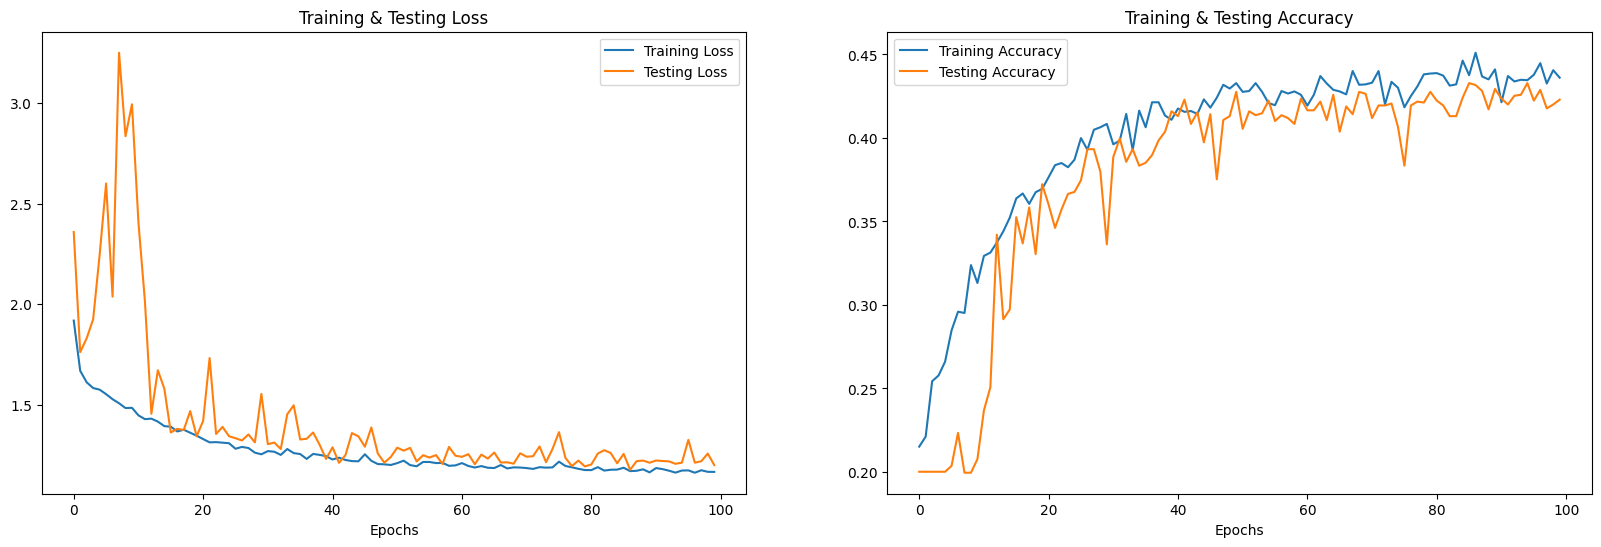

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

54/54 [==============================] - 7s 119ms/step


,Predicted Labels,Actual Labels
0,belly_pain,hungry
1,belly_pain,tired
2,belly_pain,belly_pain
3,burping,tired
4,belly_pain,belly_pain
5,burping,belly_pain
6,discomfort,discomfort
7,burping,belly_pain
8,burping,burping
9,burping,burping


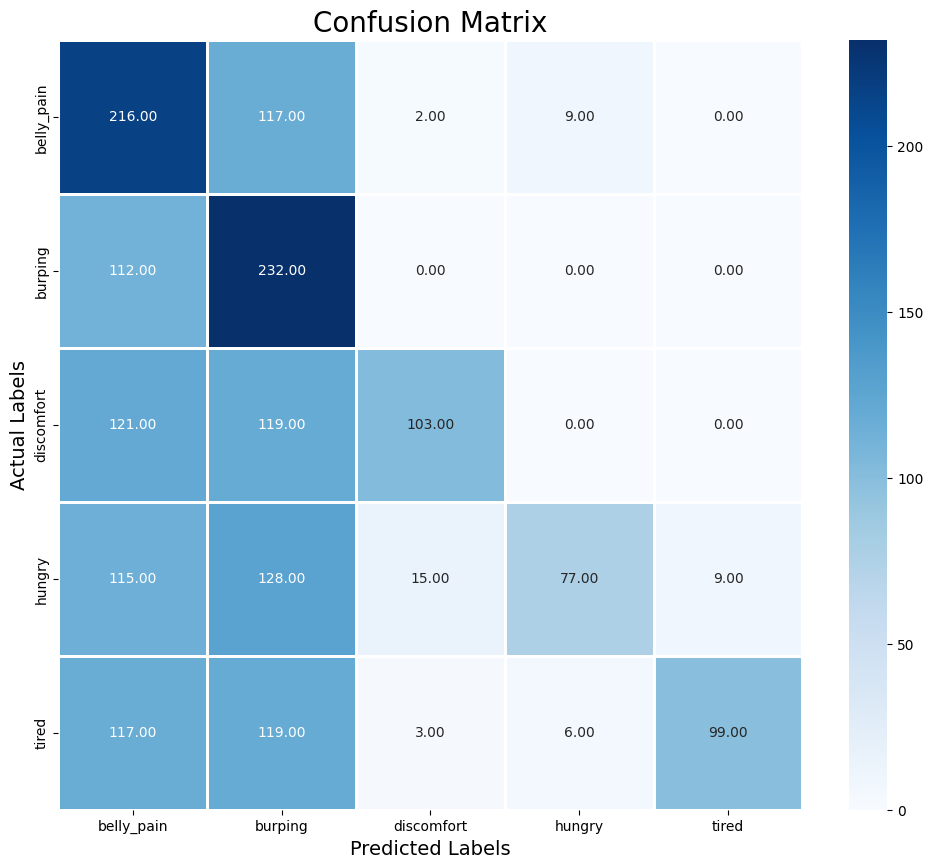

              precision    recall  f1-score   support

  belly_pain       0.32      0.63      0.42       344
     burping       0.32      0.67      0.44       344
  discomfort       0.84      0.30      0.44       343
      hungry       0.84      0.22      0.35       344
       tired       0.92      0.29      0.44       344

    accuracy                           0.42      1719
   macro avg       0.65      0.42      0.42      1719
weighted avg       0.65      0.42      0.42      1719



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

5/5 [==============================] - 1s 65ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,burping,hungry
1,belly_pain,tired
2,burping,hungry
3,burping,hungry
4,burping,discomfort
5,burping,belly_pain
6,burping,tired
7,belly_pain,hungry
8,burping,burping
9,belly_pain,belly_pain


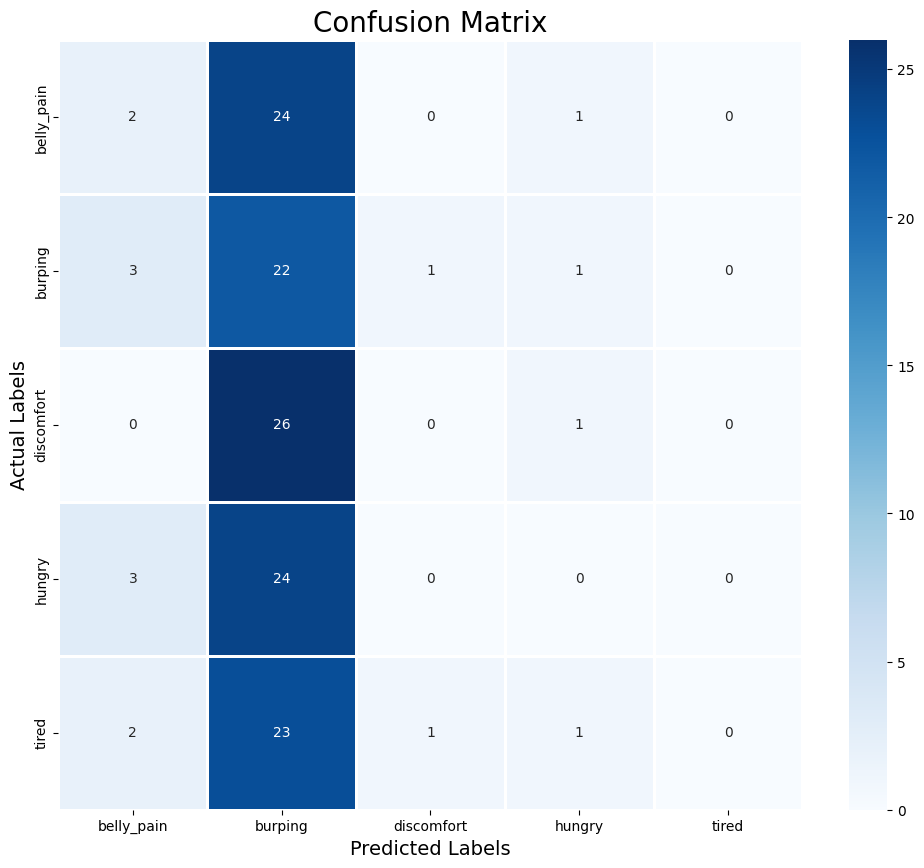

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  belly_pain       0.20      0.07      0.11        27
     burping       0.18      0.81      0.30        27
  discomfort       0.00      0.00      0.00        27
      hungry       0.00      0.00      0.00        27
       tired       0.00      0.00      0.00        27

    accuracy                           0.18       135
   macro avg       0.08      0.18      0.08       135
weighted avg       0.08      0.18      0.08       135



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
